In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
import pathlib
from sklearn.metrics import confusion_matrix

In [170]:
from google.colab import drive
drive.mount('/content/drive')
tf.config.list_physical_devices('GPU')
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 11 20:21:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |   1611MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
data_dir = pathlib.Path('/content/drive/MyDrive/Fire_recogntion_data/fire_test') 

In [55]:
# count the number of fire labels and non fire labels. 
def file_count(path):
  file_count = 0
  dirs = os.listdir(path)
  for dir in dirs:
    dir2 = path.joinpath(dir)  
    if os.path.isdir(dir2):
      file_count += len(os.listdir(dir2))

  return file_count


def learning_plot(record):
  """Function to plot the metrics"""
  fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,10))
  train_acc = record.history['accuracy']
  val_acc = record.history['val_accuracy']
  train_loss = record.history['loss']
  val_loss = record.history['val_loss']
  epoch = range(len(train_acc))
  ax1.plot(epoch, train_acc, label='Training Accuracy')
  ax2.plot(epoch, train_loss, label='Training Loss')
  ax1.plot(epoch, val_acc, label='Validation Accuracy')
  ax2.plot(epoch, val_loss, label='Validation Loss')
  ax1.set_xlabel('Epoch')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax1.set_ylabel('Accuracy')
  ax1.legend(loc = 'upper right')
  ax2.legend(loc = 'upper right')
  ax1.set_title('Learning curve of Accuracy')
  ax2.set_title('Learning curve of Loss')

# Preprocessing

### Balance the imbalanced data by up sampling the minority class

1. Copy the fire images to the size of nonfire images (I made two copies here, the original code was to repeat fire images and do image augumentation on duplicates, but RAM ran out, so I had to copy fire images on device and then read it from directory)
2. Apply image augmentation to the data 
3. Append the copied data to the original images
4. Batch data and split to test and training and validation

In [36]:
# check label distribution
fire_image_count = file_count(data_dir/'fire')
nonfire_image_count = file_count(data_dir/'no_fire')
ratio = fire_image_count / nonfire_image_count
print('The number of fire images is', fire_image_count)
print('The number of non fire images is', nonfire_image_count)
print('The ratio of fire image to non-fire image is', round(ratio, 2))

The number of fire images is 1232
The number of non fire images is 1212
The ratio of fire image to non-fire image is 1.02


### Load images from directory 

1. Resize images to height 640 and width 480 since images size ranging from (320, 240) to (1920, 1080)

2. Unbatch data since we need to combind two labels after

3. label data, fire with 1, non fire with 0

In [54]:
# Image augmentation to create more fire images
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.4, 0.4)),
  layers.experimental.preprocessing.RandomContrast(0.3)
])

# make a label dictionary for label names
label_dict = {0: 'no_fire', 1: 'fire'}
label_dict

{0: 'no_fire', 1: 'fire'}

In [38]:
img_height = 640
img_width = 480
batch_size = 32

# load fire data
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'training'
  ).map(lambda x, y: (data_augmentation(x/255.), y) )
train_size = train_ds.cardinality().numpy()
print('Train batches', train_size)


test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir, 
  seed=123, label_mode = 'int', class_names = ['no_fire', 'fire'],
  image_size=(img_height, img_width),
  batch_size = batch_size, validation_split = 0.2, subset = 'validation', 
  ).map(lambda x, y: (data_augmentation(x/255.), y) )
test_size = test_ds.cardinality().numpy()
print('Test batches', test_size)

Found 2444 files belonging to 2 classes.
Using 1956 files for training.
Train batches 62
Found 2444 files belonging to 2 classes.
Using 488 files for validation.
Test batches 16


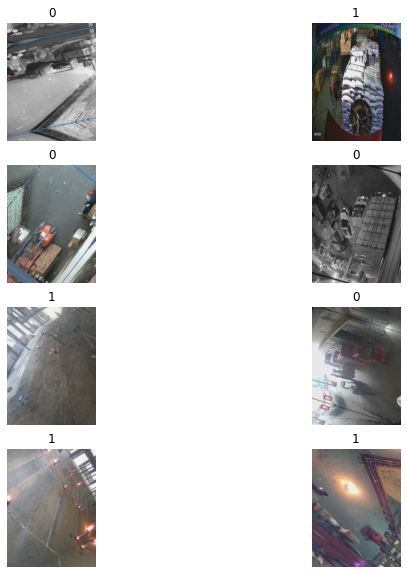

In [39]:
# Check if images loaded correctly
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1).as_numpy_iterator():
  for i in range(8):
    ax = plt.subplot(4, 2, i + 1)
    ax.imshow(images[i], vmin=0., vmax=1.,)
    plt.title(np.squeeze(labels[i]))
    plt.axis("off")

### concatenate fire and non fire data , shuffle, split to train, test, validation sets

In [40]:
val_size = int(train_size * 0.1)
test_ds = test_ds.cache().prefetch(2)
val_ds = train_ds.take(val_size).cache().prefetch(2)
train_ds = train_ds.skip(val_size).cache().prefetch(2)

In [171]:
# build model
epochs = 200
initial_learning_rate = 0.01
decay_steps = 1
decay_rate = 0.01
learning_rate = keras.optimizers.schedules.InverseTimeDecay( 
  initial_learning_rate, decay_steps, decay_rate)

def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        # Define the first convolutional layer
        layers.Conv2D(filters=64, kernel_size=(5, 5), strides=5, activation='relu'), 
        layers.BatchNormalization(),
        layers.Conv2D(filters=64, kernel_size=(3, 3), strides=3, activation='relu'), 
        layers.BatchNormalization(),
        #Define the first max pooling layer
        layers.MaxPool2D(pool_size=(4, 4), strides=2),

        # Define the second convolutional layer
        layers.Conv2D(filters=32, kernel_size=3, strides= 2, activation='relu'),
        layers.BatchNormalization(),

        # Define the second max pooling layer
        layers.MaxPool2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dense(32, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        layers.Dense(1)        
    ])
    
    return cnn_model


def compile_model(model):
  model.compile(optimizer=keras.optimizers.SGD(
                  learning_rate=learning_rate), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model


earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 verbose=1, patience=5, 
                                                 mode='min',
                                                 restore_best_weights = True ) 


cnn_model = compile_model(build_cnn_model())

In [190]:
history = cnn_model.fit(train_ds, validation_data=val_ds, epochs=epochs, 
              callbacks = earlystopping) 

Epoch 1/200
56/56 [==============================] - 2s 35ms/step - loss: 2.8129 - accuracy: 0.7846 - val_loss: 3.1762 - val_accuracy: 0.4896
Epoch 2/200
56/56 [==============================] - 2s 34ms/step - loss: 2.7326 - accuracy: 0.8390 - val_loss: 3.2802 - val_accuracy: 0.5000
Epoch 3/200
56/56 [==============================] - 2s 34ms/step - loss: 2.6813 - accuracy: 0.8690 - val_loss: 3.3164 - val_accuracy: 0.4844
Epoch 4/200
56/56 [==============================] - 2s 34ms/step - loss: 2.6450 - accuracy: 0.8923 - val_loss: 3.3033 - val_accuracy: 0.5000
Epoch 5/200
56/56 [==============================] - 2s 34ms/step - loss: 2.6176 - accuracy: 0.9093 - val_loss: 3.1688 - val_accuracy: 0.5052
Epoch 6/200
56/56 [==============================] - 2s 34ms/step - loss: 2.5921 - accuracy: 0.9223 - val_loss: 3.0661 - val_accuracy: 0.5677
Epoch 7/200
56/56 [==============================] - 2s 34ms/step - loss: 2.5706 - accuracy: 0.9291 - val_loss: 2.9122 - val_accuracy: 0.6562
Epoch 

# Evaluate the model

### 1. Plot learning curve and check model summary

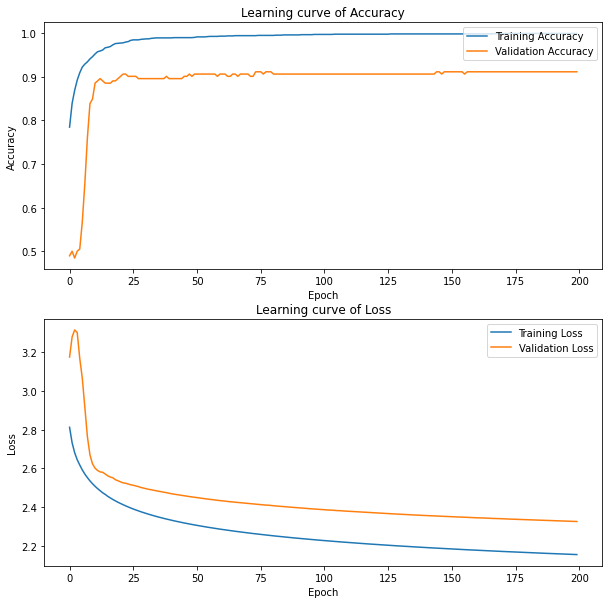

In [191]:
learning_plot(history)

In [192]:
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 96, 64)       4864      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 96, 64)       256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 42, 32, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 42, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 7, 32)          18464     
_________________________________________________________________
batch_normalization_12 (Batc (None, 9, 7, 32)         

### 2. Evaluate the model on test data

In [193]:
test_history = cnn_model.evaluate(test_ds)
print('The test accuracy is', test_history[1])
print('The test loss is', test_history[0])

16/16 [==============================] - 0s 22ms/step - loss: 2.3559 - accuracy: 0.8893
The test accuracy is 0.8893442749977112
The test loss is 2.355936050415039


### 3. Take two batch of test data and predict label directly and to see the accuracy on the two batches

In [194]:
sample = test_ds.take(2).map(lambda x,y: x)
sample_label = test_ds.take(2).map(lambda x,y: tf.squeeze(y) )
predictions = tf.sigmoid(cnn_model.predict(sample)).numpy().squeeze()
sample_labels= np.array(list(sample_label.as_numpy_iterator())).squeeze().flatten()

In [246]:
# use above 0.5 as fire, below is non-fire
predicted_labels = np.where(predictions > 0.5, 1, 0)
accuracy = np.mean(sample_labels == predicted_labels)
print('The accuracy on two sample batches is', accuracy)

The accuracy on two sample batches is 0.796875


#### check if the true labels are linear separatable by predicted probabily

In [251]:
pdf_data = np.stack([predictions, sample_labels], axis=1)
pdf_data.sort(axis=0)

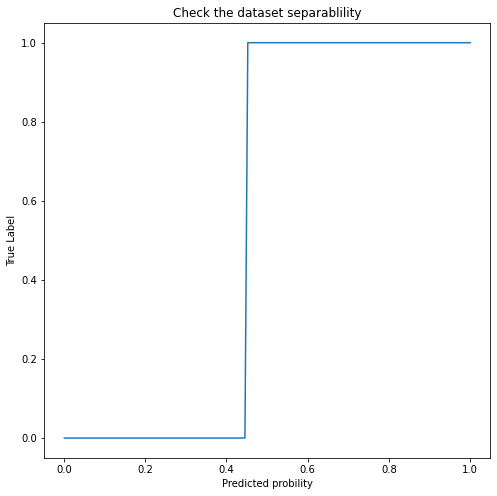

In [252]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(pdf_data[:,0], pdf_data[:,1])
ax.set_xlabel('Predicted probility')
ax.set_ylabel('True Label')
plt.title('Check the dataset separablility')
plt.show()

### 4. Plot the confusion matrix on test dataset

In [263]:
import seaborn as sns
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  f_score = cm[1][1] / (cm[1][1] + 1/2 * (cm[0][1] + cm[1][0]))
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print('TN: ', cm[0][0])
  print('FP: ', cm[0][1])
  print('FN ', cm[1][0])
  print('TP: ', cm[1][1])
  print('Total fire images: ', np.sum(cm[1]))
  print('The F score is', round(f_score, 2))

loss :  2.355936050415039
accuracy :  0.8893442749977112

TN:  220
FP:  22
FN  32
TP:  214
Total fire images:  246
The F score is 0.89


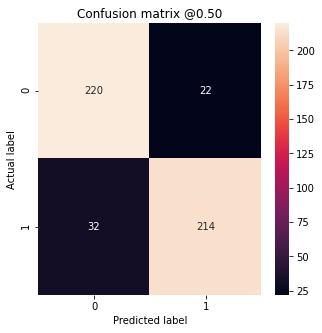

In [264]:

baseline_results = cnn_model.evaluate(test_ds, 
                                  batch_size=batch_size, verbose=0)
for name, value in zip(cnn_model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

predictions1 = cnn_model.predict(test_ds.map(lambda a,b: a) ).squeeze()
test = np.array(list(test_ds.map(lambda x,y: y).unbatch().as_numpy_iterator())).squeeze()
plot_cm(test, predictions1)

### 5. There is an issue that images were captured from not many different places. What if the model sees images from totally different scenes?  

So, I will use a brand-new dataset to test the model. This dataset is guaranteed that the model have never seens before.

The brand new dataset includes all non-fire images were misclassified as fire. So, the predictions should be all 0 (non-fire). Let's see the misclassification ratio.

In [199]:
new_data_path = os.path.abspath(data_dir.parent) + '/test_data'
os.chdir(new_data_path)

In [200]:
# !unzip nofire3.zip

In [201]:
# Do the same preprocessing process as before, do image augmentation 
# because some images have no big difference
new_data = keras.preprocessing.image_dataset_from_directory(new_data_path, 
         label_mode = None, image_size=(img_height, img_width),
  batch_size = batch_size).map(lambda x: data_augmentation(x/255.) )
new_data.cardinality().numpy()

Found 852 files belonging to 2 classes.


27

In [202]:
new_data = new_data.cache().prefetch(2)

In [203]:
new_data_prediction = tf.sigmoid(cnn_model.predict(new_data)).numpy()

In [208]:
error_ratio = np.sum(new_data_prediction >= 0.5)/ new_data_prediction.shape[0]
print('The misclassification probability is', round(error_ratio, 2))

The misclassification probability is 0.13


### Save model

In [257]:
# os.chdir('/content/drive/MyDrive/Colab Notebooks')
# model_path = os.path.abspath(os.curdir) + '/fire_model'
# if os.path.exists(model_path):
#   import shutil
#   shutil.rmtree(model_path)
#   cnn_model.save(model_path, overwrite=True)
# else:
#   cnn_model.save(model_path, overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/fire_model/assets


In [258]:
test_model = keras.models.load_model(model_path)
test_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 96, 64)       4864      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 96, 64)       256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 42, 32, 64)        36928     
_________________________________________________________________
batch_normalization_11 (Batc (None, 42, 32, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 9, 7, 32)          18464     
_________________________________________________________________
batch_normalization_12 (Batc (None, 9, 7, 32)         

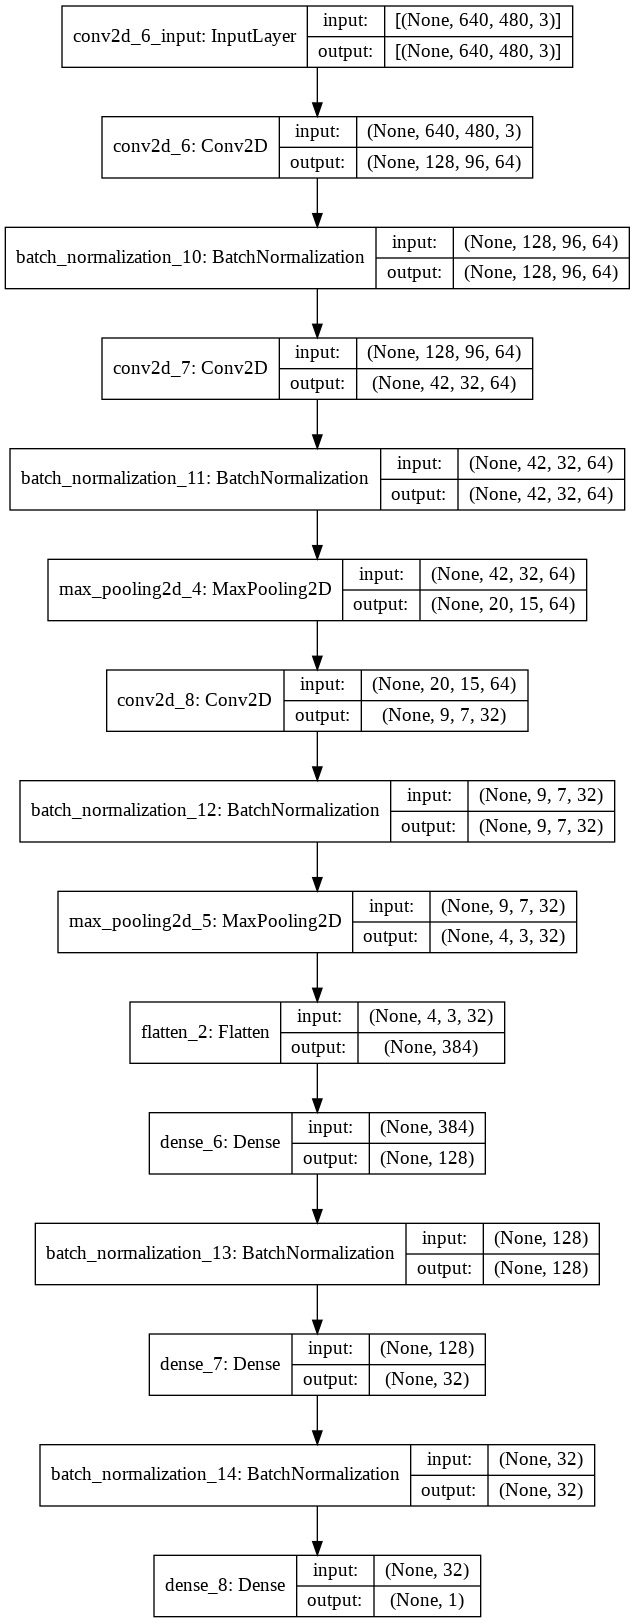

In [259]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

# Summary

1. As deep learning models are data-hungry, limited data sources would be a big problem, especial for low-variance data. Image augmentation is a solution but we still need more data. 

2. Data quality is an important factor for machine learning. My data was collected from a friend's company, the data variaty is too low since those images don't including many places. For example, this model could correctly classify images from office, factory, inventory, home, but it does not good on open space like street.

3. For real-world applications, I will spend some time on image segmentation to try multi-object detection.